## Zillow Housing Data Time Series Projections

## Setup

In [718]:
import pandas as pd
import matplotlib 
import numpy as np
from sklearn import metrics

import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

import sys
sys.path.insert(0, '../code')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
# sns.set_theme(style="darkgrid")
sns.set_theme(style="whitegrid")
%matplotlib inline
font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',400)

from code.functions import *

# EDA

## Load Data

In [719]:
# load 1 bedroom data
df_1_bd = pd.read_csv('data/Zip_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')

# load 2 bedroom data
df_2_bd = pd.read_csv('data/Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/Zip_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv'

In [ ]:
# Extract San Franciso
df_1_bd = df_1_bd[df_1_bd.CountyName == 'San Francisco County']
df_2_bd = df_2_bd[df_2_bd.CountyName == 'San Francisco County']

In [ ]:
df_1_bd.shape

In [ ]:
print("Shape of 1 Bedroom dataset for San Franciso is ", df_1_bd.shape)
print("Shape of 2 Bedroom dataset for San Franciso is ", df_2_bd.shape)

In [ ]:
df_2_bd.head()

In [ ]:
df_1_bd.head()

In [ ]:
(df_1_bd.columns == df_2_bd.columns).sum()

## Data Exploration

In [ ]:
df_1_bd.isna().sum()

In [ ]:
df_2_bd.isna().sum()

In [720]:
df_1_bd.describe()

,RegionID,SizeRank,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
count,25.000000,25.000000,25.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0

In [721]:
df_2_bd.describe()

,RegionID,SizeRank,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
count,25.000000,25.000000,25.000000,22.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23

In [722]:
len(set(df_1.zipcode))

27

In [723]:
set(df_1.zipcode)

{94102,
 94103,
 94104,
 94105,
 94107,
 '94107',
 94108,
 '94108',
 94109,
 94110,
 94111,
 94112,
 94114,
 94115,
 94116,
 94117,
 94118,
 94121,
 94122,
 94123,
 94124,
 94127,
 94131,
 94132,
 94133,
 94134,
 94158}

In [724]:
set(df_1.zipcode)==set(df_2.zipcode)

False

## Reshape DataFrame

In order to run time series analysis, we must reshape our DataFrame from Wide to Long Format.

In [725]:
df_1_melt = melt_data(df_1_bd)
df_2_melt = melt_data(df_2_bd)
columns = ['RegionName', 'date', 'value']
df_1 = df_1_melt[columns]
df_2 = df_2_melt[columns]
df_1.columns = ['zipcode', 'date', 'value']
df_2.columns = ['zipcode', 'date', 'value']

In [726]:
df_1

,zipcode,date,value
0,94109,1996-01-31,260256.0
1,94110,1996-01-31,217471.0
2,94122,1996-01-31,288096.0
3,94112,1996-01-31,204717.0
4,94115,1996-01-31,218208.0
...,...,...,...
7545,94127,2021-02-28,1414935.0
7546,94108,2021-02-28,789435.0
7547,94158,2021-02-28,998991.0
7548,94111,2021-02-28,933245.0


In [727]:
df_2

,zipcode,date,value
0,94109,1996-01-31,395027.0
1,94110,1996-01-31,244323.0
2,94122,1996-01-31,270792.0
3,94112,1996-01-31,226713.0
4,94115,1996-01-31,304296.0
...,...,...,...
7545,94127,2021-02-28,1488832.0
7546,94108,2021-02-28,1502923.0
7547,94158,2021-02-28,1513017.0
7548,94111,2021-02-28,1466530.0


Create separate DataFrames for 1-bedroom homes and 2-bedroom homes averaged by zip 

In [728]:
sf_1_all = df_1.groupby('date').aggregate({'value':'mean'})
sf_2_all = df_2.groupby('date').aggregate({'value':'mean'})

In [729]:
sf_1_all

,value
date,
1996-01-31,252714.043478
1996-02-29,252364.478261
1996-03-31,251782.391304
1996-04-30,251039.652174
1996-05-31,250138.260870
1996-06-30,249686.086957
1996-07-31,249109.434783
1996-08-31,249207.956522
1996-09-30,249520.565217


## Visualization

In [730]:
years = mdates.YearLocator()             # only print whole years
years_fmt = mdates.DateFormatter('%Y')   

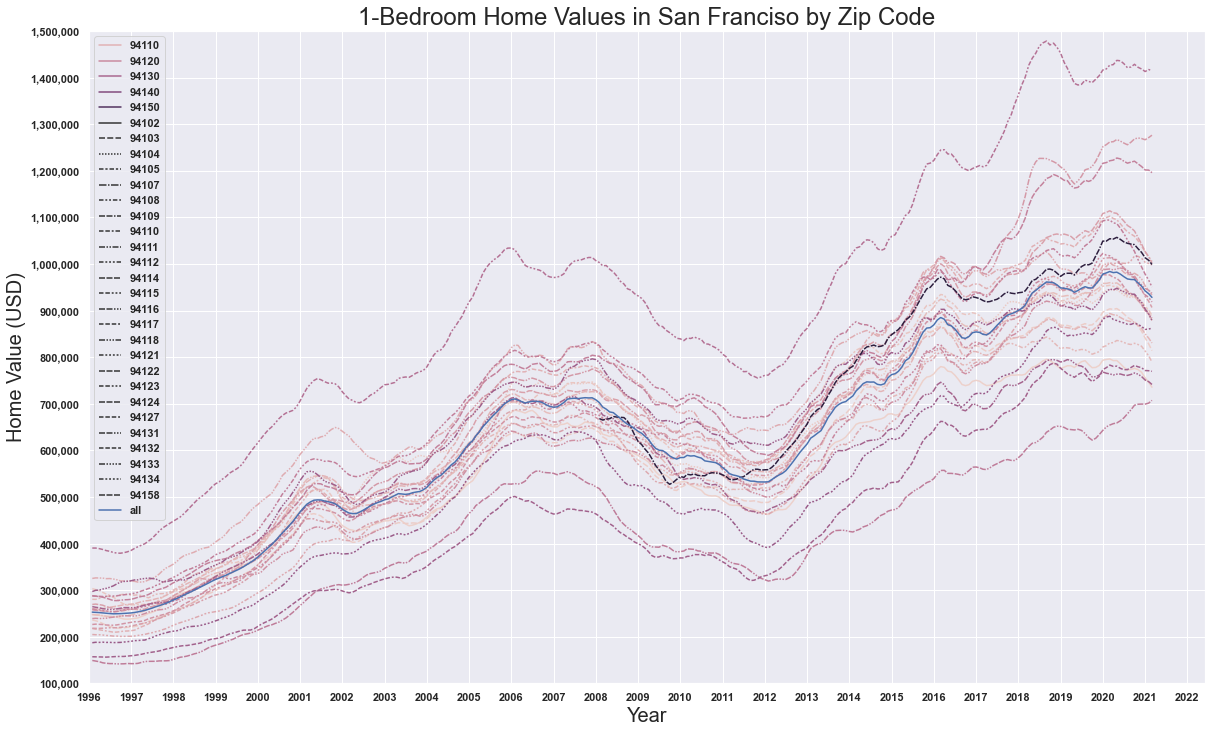

In [731]:
# sns.set_palette('cubehelix', 1) 
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('1-Bedroom Home Values in San Franciso by Zip Code', size=24)
sns.lineplot(data=df_1, x=df_1.date, y=df_1.value, ax=ax, hue='zipcode', style='zipcode')
sns.lineplot(data=sf_1_all, x=sf_1_all.index, y=sf_1_all.value, ax=ax, color = 'b', label='all')
ax.set_xlabel('Year',  size=20)
ax.set_ylabel('Home Value (USD)', size=20)
ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.set_yticks(np.linspace(1e5,1.5e6,15))
ax.set_ylim((1e5, 1.5e6))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig('images/1_bdrm_home_values.png')

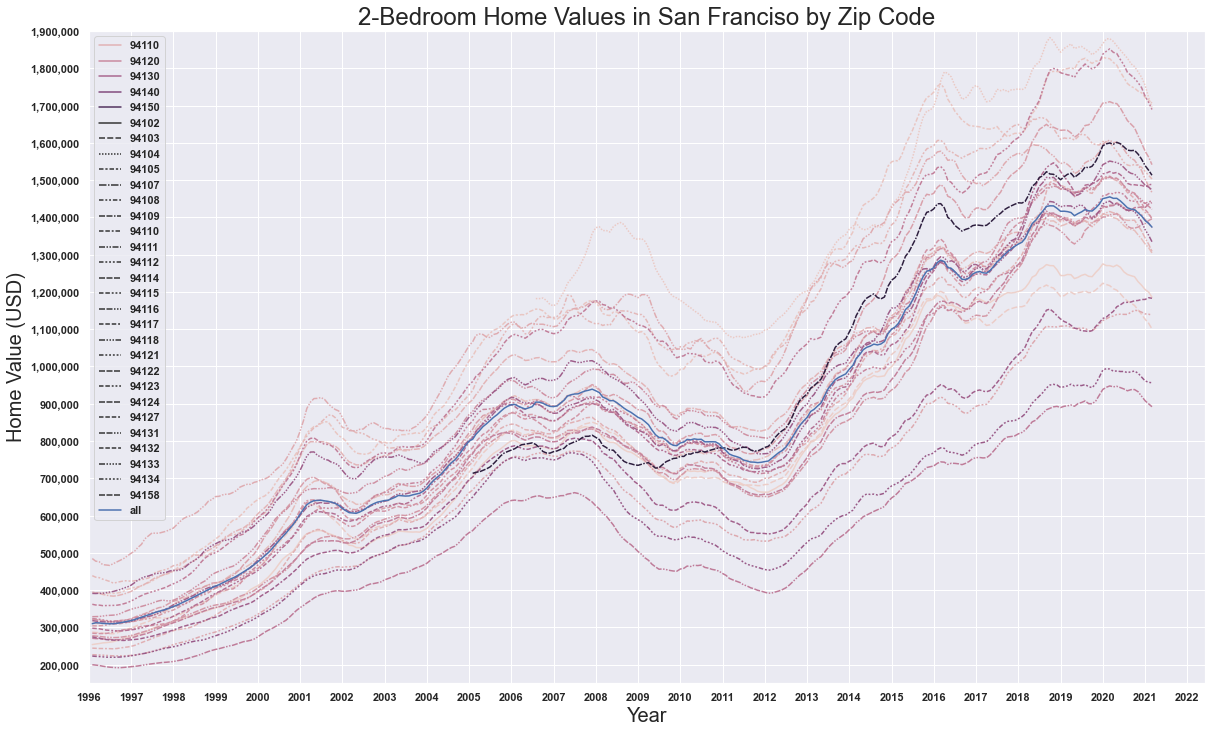

In [732]:
# sns.set_palette('cubehelix', 1) 
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('2-Bedroom Home Values in San Franciso by Zip Code', size=24)
sns.lineplot(data=df_2, x=df_2.date, y=df_2.value, ax=ax, hue='zipcode', style='zipcode')
sns.lineplot(data=sf_2_all, x=sf_2_all.index, y=sf_2_all.value, ax=ax, color = 'b', label='all')
ax.set_xlabel('Year',  size=20)
ax.set_ylabel('Home Value (USD)', size=20)
ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.set_yticks(np.linspace(2e5,1.9e6,18))
ax.set_ylim((1.5e5, 1.9e6))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig('images/2_bdrm_home_values.png')

# Data Prep

In [733]:
# Pad two Zip Codes with NaNs
df_1 = df_1.append({'zipcode': '94107', 'date': '1996-01-31', 'value': np.NaN}, ignore_index=True)
df_1 = df_1.append({'zipcode': '94108', 'date': '1996-01-31', 'value': np.NaN}, ignore_index=True)

## Prepare Data Structure

In [711]:
zipcodes = list(set(df_1.zipcode))
keys = [zipcode for zipcode in map(str, zipcodes)]
# keys_1 = [zipcode for zipcode in map(str, zipcodes)]
# keys_2 = [zipcode for zipcode in map(str, zipcodes)]
sf_1_list = sf_2_list = []

for zipcode in zipcodes:
    sf_1_list.append(df_1[df_1.zipcode == zipcode])
    sf_1_list[-1].drop('zipcode', inplace=True, axis=1)
#     sf_1_list[-1].columns = ['date', 'value']
    sf_1_list[-1].date = pd.to_datetime(sf_1_list[-1].date)
    sf_1_list[-1].set_index('date', inplace=True)
    sf_1_list[-1] = sf_1_list[-1].asfreq('M')
    
    sf_2_list.append(df_2[df_2.zipcode == zipcode])
    sf_2_list[-1].drop('zipcode', inplace=True, axis=1)
#     sf_1_list[-1].columns = ['date', 'value']
    sf_2_list[-1].date = pd.to_datetime(sf_2_list[-1].date)
    sf_2_list[-1].set_index('date', inplace=True)
    sf_2_list[-1] = sf_2_list[-1].asfreq('M')

sf_1_dict = dict(zip(keys, sf_1_list))
sf_2_dict = dict(zip(keys, sf_2_list))
# sf_1_dict = dict(zip(keys_1, sf_1_list))
# sf_2_dict = dict(zip(keys_2, sf_2_list))

## Test Stationarity

### 1-Bedroom Home Values

In [358]:
# Undifferenced data
dftest = adfuller(sf_1_all)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                  -1.793011
p-value                          0.383937
#Lags Used                      16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [359]:
# Differenced data
dftest = adfuller(sf_1_all.diff().dropna())
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                  -2.316876
p-value                          0.166583
#Lags Used                      15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [471]:
# Twice-Differenced data
dftest = adfuller(sf_1_all.diff().diff().dropna())
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                -7.097080e+00
p-value                        4.261762e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


### 2-Bedroom Home Values

In [417]:
# Undifferenced data
dftest = adfuller(sf_2_all)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                  -1.400165
p-value                          0.582197
#Lags Used                      16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [472]:
# Once-Differenced data
dftest = adfuller(sf_2_all.diff().dropna())
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                  -2.425809
p-value                          0.134584
#Lags Used                      15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [473]:
# Twice-Differenced data
dftest = adfuller(sf_2_all.diff().diff().dropna())
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                -6.661065e+00
p-value                        4.845806e-09
#Lags Used                     1.400000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


In [485]:
for zipcode, df in sf_1_dict.items():
    dftest = adfuller(df.diff().dropna())
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput[1])

0.1926145455165832
0.2060422729459903
0.28775511977713875
0.07993566297172833
0.12863966926350828
0.09891970954011631
0.08290320249362182
0.3111836117777681
0.13715105283198115
0.14637328895676732
0.17271856642597144
0.1337574409333543
0.06464975186815168
0.09976068994950421
0.07803295357584289
0.3662963961134048
0.10228118941553666
0.28197131317300095
0.08767823497608018
0.07952584152580128
0.17592392816866875
0.16263008723813865
0.04817661237234456
0.2480195401331708
0.09750369141922782


In [486]:
for zipcode, df in sf_2_dict.items():
    dftest = adfuller(df.diff().dropna())
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput[1])

0.2229988866563588
0.20341818104256465
0.24390284407782337
0.030833635274431278
0.12383926158723568
0.07283425733482167
0.19879946976070362
0.11240533490243582
0.08577133012198046
0.16711867703126432
0.2127939064194314
0.16509636409843742
0.05097122573040681
0.15619218111390498
0.07190436345815086
0.25625231439948004
0.029105514316216642
0.2677355065731407
0.1442688188097958
0.02175184603117924
0.09244256234062642
0.031485249237360576
0.12534484435935578
0.17940667945630767
0.5028144750781229


## Plot ACF and PACF

### 1-Bedroom Home Values

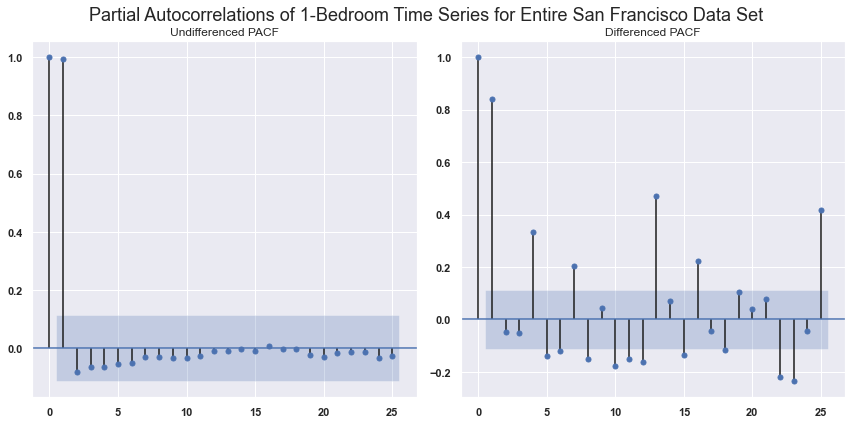

In [263]:
pacf_1_fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pacf_1_fig.suptitle('Partial Autocorrelations of 1-Bedroom Time Series for Entire San Francisco Data Set', fontsize=18)
plot_pacf(sf_1_all, ax=ax[0])
ax[0].set_title('Undifferenced PACF')
plot_pacf(sf_1_all.diff().dropna(), ax=ax[1])
ax[1].set_title('Differenced PACF')
pacf_1_fig.tight_layout()
pacf_1_fig.subplots_adjust(top=0.9)
plt.savefig('images/1_bdrm_PACF.png')

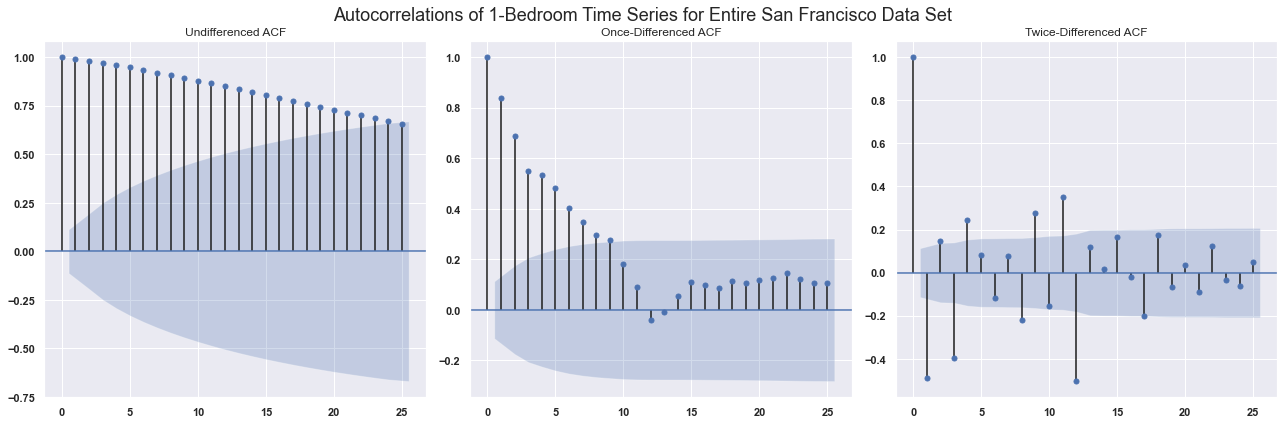

In [273]:
acf_1_fig, ax = plt.subplots(1, 3, figsize=(18, 6))
acf_1_fig.suptitle('Autocorrelations of 1-Bedroom Time Series for Entire San Francisco Data Set', fontsize=18)
plot_acf(sf_1_all, ax=ax[0])
ax[0].set_title('Undifferenced ACF')
plot_acf(sf_1_all.diff().dropna(), ax=ax[1])
ax[1].set_title('Once-Differenced ACF')
plot_acf(sf_1_all.diff().diff().diff().dropna(), ax=ax[2])
ax[2].set_title('Twice-Differenced ACF')
acf_1_fig.tight_layout()
acf_1_fig.subplots_adjust(top=0.9)
plt.savefig('images/1_bdrm_ACF.png')

### 2-Bedroom Home Values

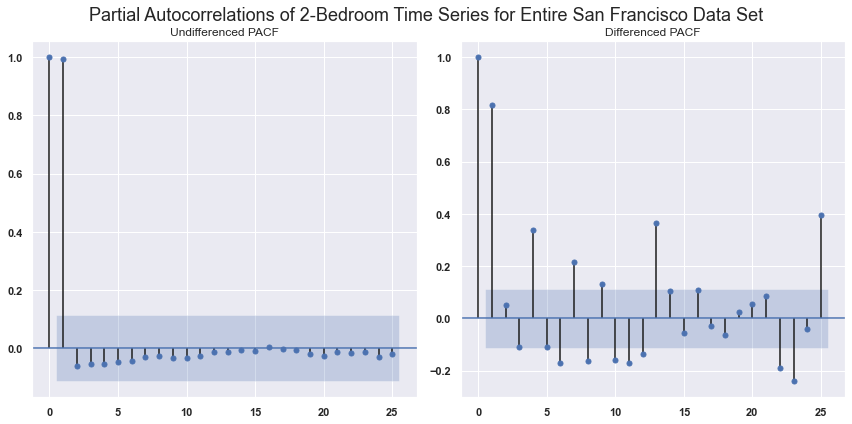

In [270]:
pacf_2_fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pacf_2_fig.suptitle('Partial Autocorrelations of 2-Bedroom Time Series for Entire San Francisco Data Set', fontsize=18)
plot_pacf(sf_2_all, ax=ax[0])
ax[0].set_title('Undifferenced PACF')
plot_pacf(sf_2_all.diff().dropna(), ax=ax[1])
ax[1].set_title('Differenced PACF')
pacf_2_fig.tight_layout()
pacf_2_fig.subplots_adjust(top=0.9)
plt.savefig('images/2_bdrm_PACF.png')

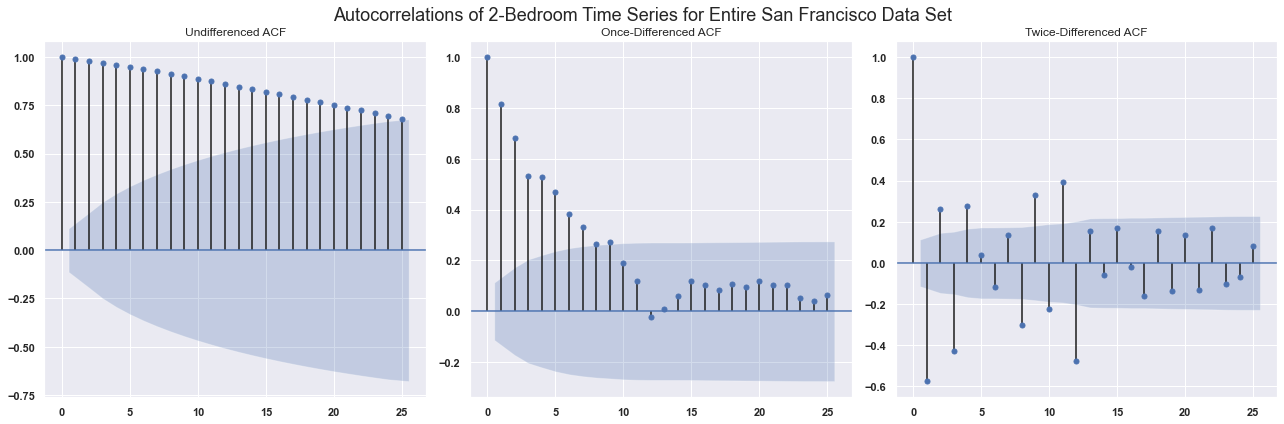

In [272]:
acf_2_fig, ax = plt.subplots(1, 3, figsize=(18, 6))
acf_2_fig.suptitle('Autocorrelations of 2-Bedroom Time Series for Entire San Francisco Data Set', fontsize=18)
plot_acf(sf_2_all, ax=ax[0])
ax[0].set_title('Undifferenced ACF')
plot_acf(sf_2_all.diff().dropna(), ax=ax[1])
ax[1].set_title('Once-Differenced ACF')
plot_acf(sf_2_all.diff().diff().diff().dropna(), ax=ax[2])
ax[2].set_title('Twice-Differenced ACF')
acf_2_fig.tight_layout()
acf_2_fig.subplots_adjust(top=0.9)
plt.savefig('images/2_bdrm_ACF.png')

## Plot Seasonal Decomposition

### 1-Bedroom Home Values

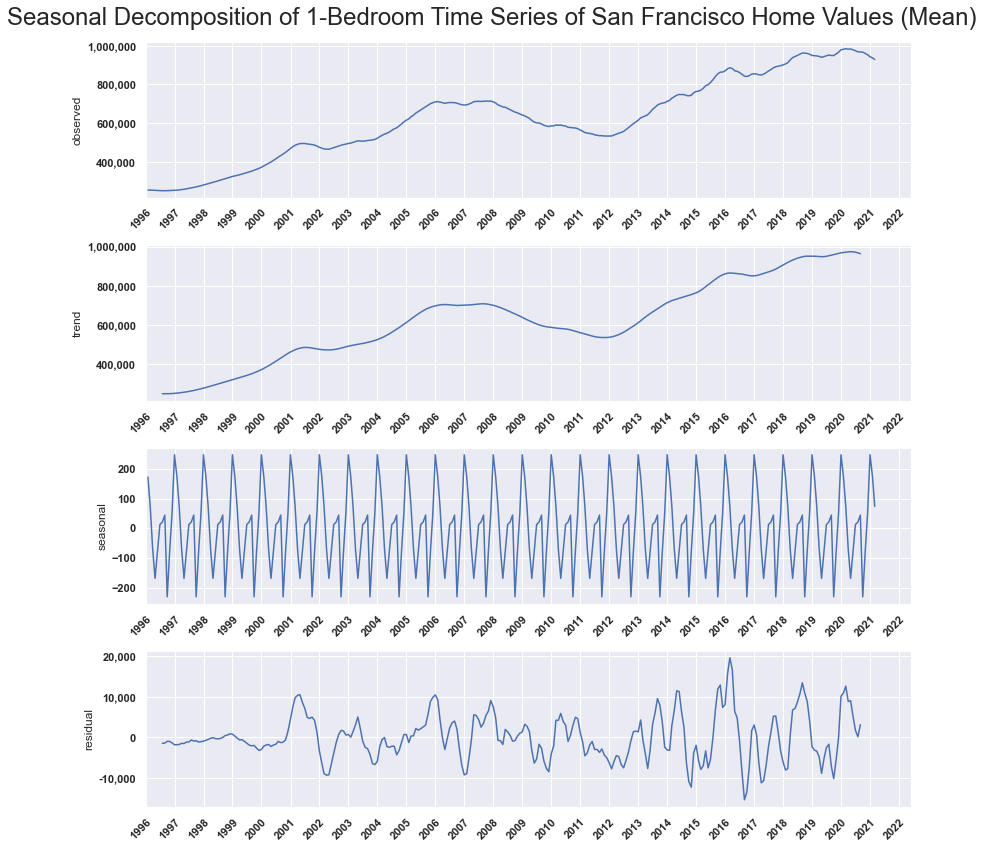

In [326]:
decomp_1 = seasonal_decompose(sf_1_all, freq=12)
dc_1_obs = decomp_1.observed
dc_1_trend = decomp_1.trend
dc_1_seas = decomp_1.seasonal
dc_1_resid = decomp_1.resid
dc_1_df = pd.DataFrame({"observed": dc_1_obs, "trend": dc_1_trend,
                        "seasonal": dc_1_seas, "residual": dc_1_resid})
decomp_1_fig, axes = plt.subplots(4, 1, figsize=(12, 12))

for i, ax in enumerate(axes):
    ax.plot(dc_1_df.iloc[:, i])
    ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.set_ylabel(dc_1_df.iloc[:, i].name)
    if i != 2:
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
    
decomp_1_fig.suptitle(
    'Seasonal Decomposition of 1-Bedroom Time Series of San Francisco Home Values (Mean)', fontsize=24)
decomp_1_fig.tight_layout()
decomp_1_fig.subplots_adjust(top=0.94)
plt.savefig('images/1_bdrm_seasonal_decomp.png')

### 2-Bedroom Home Values

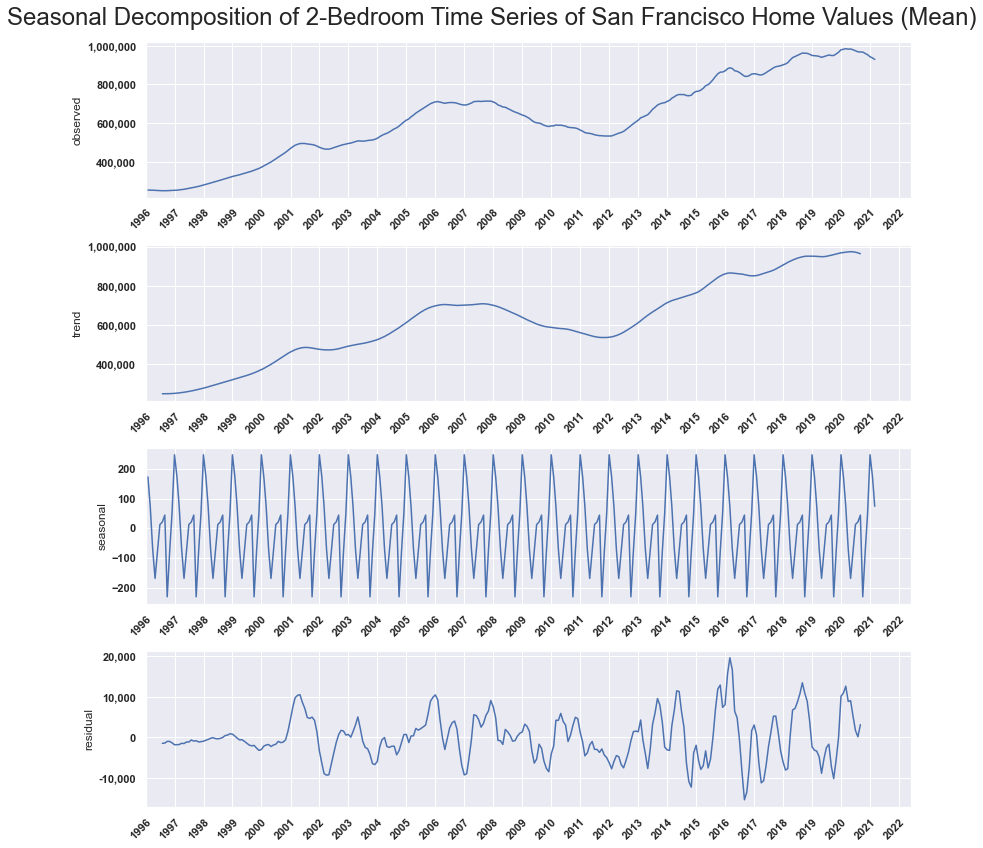

In [327]:
decomp_2 = seasonal_decompose(sf_2_all, freq=12)
dc_2_obs = decomp_1.observed
dc_2_trend = decomp_1.trend
dc_2_seas = decomp_1.seasonal
dc_2_resid = decomp_1.resid
dc_2_df = pd.DataFrame({"observed": dc_2_obs, "trend": dc_2_trend,
                        "seasonal": dc_2_seas, "residual": dc_2_resid})
decomp_2_fig, axes = plt.subplots(4, 1, figsize=(12, 12))

for i, ax in enumerate(axes):
    ax.plot(dc_2_df.iloc[:, i])
    ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.set_ylabel(dc_2_df.iloc[:, i].name)
    if i != 2:
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
    
decomp_2_fig.suptitle(
    'Seasonal Decomposition of 2-Bedroom Time Series of San Francisco Home Values (Mean)', fontsize=24)
decomp_2_fig.tight_layout()
decomp_2_fig.subplots_adjust(top=0.94)
plt.savefig('images/2_bdrm_seasonal_decomp.png')

# ARIMA Modeling

## Perform Train-Test Split

In [745]:
def train_test_split_housing(data_dict):
    cutoff = round(len(data_dict[list(data_dict.keys())[0]])*.8)
    train_dict_list = [data_dict[i][:cutoff] for i in list(data_dict.keys())]
    train_dict = dict(zip(list(data_dict.keys()), train_dict_list))
    test_dict_list = [data_dict[i][cutoff:] for i in list(data_dict.keys())]
    test_dict = dict(zip(list(data_dict.keys()), test_dict_list))
    return train_dict, test_dict

In [746]:
sf_1_train_dict, sf_1_test_dict = train_test_split_housing(sf_1_dict)
sf_2_train_dict, sf_2_test_dict = train_test_split_housing(sf_2_dict)

In [747]:
for k, v in sf_1_dict.items():
    print(k,len(v))
for k, v in sf_2_dict.items():
    print(k,len(v))

94102 302
94103 302
94104 302
94105 302
94107 302
94108 302
94109 302
94110 301
94111 302
94112 302
94114 302
94115 302
94116 302
94117 302
94118 302
94121 302
94122 302
94123 302
94124 302
94127 302
94131 302
94132 302
94133 302
94134 302
94158 302
94102 302
94103 302
94104 302
94105 302
94107 302
94108 302
94109 302
94110 301
94111 302
94112 302
94114 302
94115 302
94116 302
94117 302
94118 302
94121 302
94122 302
94123 302
94124 302
94127 302
94131 302
94132 302
94133 302
94134 302
94158 302


In [748]:
# cutoff = round(len(sf_1_dict[list(sf_1_dict.keys())[0]])*.8)

# sf_1_train_dict_list = [sf_1_dict[i][:cutoff] for i in list(sf_1_dict.keys())]
# sf_1_train_dict = dict(zip(list(sf_1_dict.keys()), sf_1_train_dict_list))

# sf_2_train_dict_list = [sf_2_dict[i][:cutoff] for i in list(sf_2_dict.keys())]
# sf_2_train_dict = dict(zip(list(sf_2_dict.keys()), sf_2_train_dict_list))

## Manual GridSearch of Model Parameters

In [749]:
# p = range(2, 3)
# q = range(1, 3)
# s_p = range(2, 3)
# s_q = range(1, 3)
# pdq = list(itertools.product(p, [1], q))
# # seasonal_pdq = list(itertools.product(s_p, [1], s_q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(s_p, [1], s_q))]
# print('Examples of parameter for SARIMA...')
# for i in pdq:
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i, s))

In [750]:
# # auto_arima(sf_1_all,seasonal=True,m=12).summary()
# auto_arima(sf_1_train_dict['1_bdrm_97557'],seasonal=True,m=12).summary()


In [751]:
def gridsearch_SARIMAX(train_dict, seas = 12, p_min=2, p_max=2, q_min=1, q_max=2, d_min=1, d_max=2,
                       s_p_min=2, s_p_max=2, s_q_min=1, s_q_max=2, s_d_min=1, s_d_max=2):
    p = range(p_min, p_max+1)
    q = range(q_min, q_max+1)
    d = range(d_min, d_max+1)
    s_p = range(s_p_min, s_p_max+1)
    s_q = range(s_q_min, s_q_max+1)
    s_d = range(s_d_min, s_d_max+1)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seas) for x in list(itertools.product(s_p, s_d, s_q))]
    print('Parameter for SARIMAX grid search...')
    for i in pdq:
        for s in seasonal_pdq:
            print('SARIMAX: {} x {}'.format(i, s))
    
    zipcodes = []
    param_list = []
    param_seasonal_list = []
    aic_list = []

    for zipcode, train in train_dict.items():
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                mod = SARIMAX(train,
                              order=param,
                              seasonal_order=param_seasonal,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                zipcodes.append(zipcode[-5:])
                param_list.append(param)
                param_seasonal_list.append(param_seasonal)
                aic = mod.fit().aic
                aic_list.append(aic)
                print(aic)
    return zipcodes, param_list, param_seasonal_list, aic_list

In [752]:
zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list = gridsearch_SARIMAX(sf_1_train_dict)
zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list = gridsearch_SARIMAX(sf_1_train_dict)

Parameter for SARIMAX grid search...
SARIMAX: (2, 1, 1) x (2, 1, 1, 12)
SARIMAX: (2, 1, 1) x (2, 1, 2, 12)
SARIMAX: (2, 1, 1) x (2, 2, 1, 12)
SARIMAX: (2, 1, 1) x (2, 2, 2, 12)
SARIMAX: (2, 1, 2) x (2, 1, 1, 12)
SARIMAX: (2, 1, 2) x (2, 1, 2, 12)
SARIMAX: (2, 1, 2) x (2, 2, 1, 12)
SARIMAX: (2, 1, 2) x (2, 2, 2, 12)
SARIMAX: (2, 2, 1) x (2, 1, 1, 12)
SARIMAX: (2, 2, 1) x (2, 1, 2, 12)
SARIMAX: (2, 2, 1) x (2, 2, 1, 12)
SARIMAX: (2, 2, 1) x (2, 2, 2, 12)
SARIMAX: (2, 2, 2) x (2, 1, 1, 12)
SARIMAX: (2, 2, 2) x (2, 1, 2, 12)
SARIMAX: (2, 2, 2) x (2, 2, 1, 12)
SARIMAX: (2, 2, 2) x (2, 2, 2, 12)
3944.6826570453654
3946.6548343416334
3918.538461627806


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3901.445624443655


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3925.472243135768
3916.118714969948
3900.4303821395506
3858.9131150695544
3917.7205944182724
3918.8988836519734


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3879.5083481905085


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4202.156852155509
3939.1998766859956
3921.788323028695
3907.050234189547
4253.733264242224
4034.0127395434038
4035.354460238929
3951.9683850187275


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3950.723054495197
4030.1188228087176
4004.773501548692
3973.303391225818
3921.312098592778
4022.9293510790853
4022.6725968966116
3947.153999979136
4335.869477542501
4030.8476544159917


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4011.5468624262035
3962.5033096947795
4336.5382844792875
3888.9287306988754


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3890.844494042126


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3821.1582814235544
4975.860050392155
3884.5689008721934
3864.463620185851
3836.798409738437
3802.170134935689
3876.950443865282
3878.0151566004015
3818.1364540401864
3818.130515008812
3889.8580036143644
3869.2713703632926
3850.970833631855


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3995.596042268432
3994.6179685043135


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3998.9556645963303
3947.4218751334033


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3924.5561674061437
3990.183286948594
3969.6628254607026
3939.831482094315


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3894.801961628459
3980.973337713217
3980.8359187036413
3921.916661026746
4275.924132960493
3995.3478564616917
3974.696843146742
3939.6320384832193
4310.885776092074
4038.99436013623
4035.3930902416023
3960.1917183909127


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3959.4030704789384
4029.422875284609
4010.0132830082293
3978.129090447257


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3930.4992340915596
4014.1999926272147
4015.5174287234427
3951.8239429283913
3952.4781278576124
4034.5329937118436
4014.952135573425
3971.9671140076907
3953.060860873138


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3935.004461983042
3953.207068224007
3882.812133384848


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3883.6607534880495
3944.9321806670787
3924.4618467202845
3891.8389112453765


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3847.4732955031905


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3932.219643952882


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5795.031732170312
3865.772781456295


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4548.236987671438
3955.6803561560405


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3878.6597603359596
3912.741971846298


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3894.086566776933
3949.5717188006265


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3951.151708066299


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3897.9559260355027


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5542.725590756846
3947.4853043261073
3929.057149508817
3891.462335735268
3848.4419159300214
3926.9694996495405


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3930.1298498319097
3866.737206379198


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4134.881558288469
3945.6749850741007


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3874.968957723139
3888.799866462472


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4261.822942475576
4187.170493487691
4188.349347994701
4126.2882554052185


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4097.51088087156
4177.488862429325
4150.367229330708
4110.6395639332895


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4052.6426900193355
4159.746676354213
4159.967701670784
4078.1048660763017


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4077.801213087952
4194.181583469226
4170.296770852878
4125.182091082369
4104.12587895152
3901.76268733201


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3903.6711373268568
3828.3021220853534


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3830.137082596644
3898.2908366955216
3876.442139166849
3848.0308266596503
3801.554512919015
3887.146833889297
3894.7059303700134
3827.712373370702
3828.110247722111
3899.274232703909


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3827.738363073444


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3745.478818895473
3821.3990856508217
4057.849568224415
4056.5086193269217
3981.591486321943


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3981.646688499627
4051.195194361199
4030.226237455918
3996.9864244484975
3950.7559425737427


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4038.115099022699
4037.4560775765112
3972.591727533588
4236.546521182496
4056.875937259707
4037.650338797086
3996.115710537423
4395.102448865608
3942.1921325361777


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4908.392093754444


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3877.994023784662
5012.22716290249
3937.344677342139
3916.610388016087
3892.6440469784507
3853.566907086386
3927.9702874869927


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4297.491217773084
3872.9367177139347


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4082.972350964662
3944.830151323318
4309.445915040786
3894.5100993053893
4244.45033155105
4241.3219668810325
4242.688928334275
4176.927295464053
4150.708413249096
4237.1837509905745
4214.395907940202
4168.981860355507
4116.036276711454


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4428.982623549508


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4787.824636175182
4146.350503413738


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4168.542730993737
4248.559170650057
4227.7619698661965
4172.4496251205255
4159.361199516312
3923.7359145308806


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3938.9696866620666


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3880.1686197924228


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4895.598373675179
3921.0687507010334
3903.4532934841627
3874.308004096579
3833.3283757277177
3905.9818873371783


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3907.9029176260924
3851.926914807612
4047.6744143603973
3925.485434503805


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4241.148112196802
3873.07838900283
3853.644165222651
4069.8362319466255
4070.056817042236
3986.005721985375


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4055.3366323659184
4067.5254368644037
4046.4622706626933
4007.3296858173903
3956.8362572079304
4055.9440626166515
4054.9712612619637
3985.2769891284397
3984.3018117704687
4072.453281904719
4051.4217122084847
4003.3706158011173
3983.5701860468143
3969.486479535685
3971.418390871383
3920.5251791274723
3901.281576722682
3966.4676771029153
3949.0750298630746
3909.028074455587
3866.4394570326726
3920.343201475704
3945.714377657756
3878.550071457715
4104.054532796656


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3952.997115690753
3945.202255150306
3903.501807789575


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3884.9598268682644
4041.2442564560215
4043.2398999380775
3990.359218328044
3964.8589122026297
4038.3295706995677
4016.2072572651623
3956.6197846939676
3936.7176851356917
4024.4762734992582


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4026.446548469884
3963.145113808305


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3964.5583474060613
4042.0400596607897
4023.9122439667444
3984.585872303239
4264.744087335095
4218.459872480937
4220.979307708908
4131.47600143919
4128.886632900883
4210.079162633738
4188.270221595956
4108.631413047965
4087.0540335816954


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4207.464096332429


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4208.468290139921
4147.752380405347


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5177.792940796116
4220.961302441787
4196.919825877375
4138.103270413853


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4117.468065975536


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3914.7808933237375
5238.888832400136
3837.2071909128317


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4027.6513832517594
3912.4594399639354
3891.7718810495535
3860.2770294827974
3809.002067882476
3902.703964652475
3903.59240462482
3829.777550698006
3830.047632097981


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3909.534352298451
3895.806078176915
3853.0837921890798


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3835.1346126198514


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3889.883221447469
3925.536354021944
3849.075966610311


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3849.5816485699665
3921.4904666873563
3900.701526309437
3869.3451419536573
3821.801499001093
3904.153722949499


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3909.1999894601745
3839.7052440900106


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3841.5694013146826


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3901.9059727414055
4487.595313690814
3865.962673303673


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4019.351013462395
4009.7905098960723
4011.6634565694303
3957.9143873566227
3932.800709413657
4007.4147811890425
3988.121781984609
3949.019309810991
3898.968403648207
3988.461537667447


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4328.278158715344
3914.5677648370383
4320.50307441392
4008.0828683967975


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4074.013551276361
3940.1433811062884


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4160.879543393427
4103.692912463404
4105.690521250301
4049.0285788836754


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4025.148669037684
4099.303564524862
4079.7880398568623
4035.0915281043117
3996.3730426718744
4083.7062069412086
4085.650650697263
4008.602445132896


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4288.40811528196
4108.052539750159
4088.2800951752693
4043.384164299074


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4454.850582544714
3943.8999254314263
3945.369783902891
3890.633338439546


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3859.750662199031
3938.3621982914965
3917.9257663448097
3883.0172313228654
3840.68081100758
3930.8522142535817
4264.902221022046
3855.7706146755927


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3856.800142404103
3953.8179979787583


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3893.2278129285914
3884.2651180130088
4238.01148275674
4072.3274089957913
4073.71214192121
4019.6640091821932
3989.8153784714286
4065.528281415054
4045.1185573367284
4005.1832299484813
3963.2135116167183
4053.1356867897757
4053.98682752808
3980.453359602302


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4275.135889446482
4073.93969449669
4460.12625889065
4009.3557733625116


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4255.792128570105
3931.256743055774
3932.6458270987787
3885.957330832893
3865.173721923071
3925.347997821242
3905.787116273138
3876.489976342755
3831.3039610058745


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5013.3577629448955


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5020.472671978367
3855.9813922067924
4051.775741803307


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3882.0933941921385
3912.8064934602253
3878.7149276479827


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4060.283259598384
3996.643719477059


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3949.475204031526
3888.0223260644916


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3863.1800080786347
3942.463176794831
3922.5305068227676
3883.460406505771


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3838.143066972491
3933.9444498712132
3934.161092529444
3864.2364993670867
4229.23901033641
3946.539023769435


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4297.783407770003
3881.47538479172


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3826.713626223353
Parameter for SARIMAX grid search...
SARIMAX: (2, 1, 1) x (2, 1, 1, 12)
SARIMAX: (2, 1, 1) x (2, 1, 2, 12)
SARIMAX: (2, 1, 1) x (2, 2, 1, 12)
SARIMAX: (2, 1, 1) x (2, 2, 2, 12)
SARIMAX: (2, 1, 2) x (2, 1, 1, 12)
SARIMAX: (2, 1, 2) x (2, 1, 2, 12)
SARIMAX: (2, 1, 2) x (2, 2, 1, 12)
SARIMAX: (2, 1, 2) x (2, 2, 2, 12)
SARIMAX: (2, 2, 1) x (2, 1, 1, 12)
SARIMAX: (2, 2, 1) x (2, 1, 2, 12)
SARIMAX: (2, 2, 1) x (2, 2, 1, 12)
SARIMAX: (2, 2, 1) x (2, 2, 2, 12)
SARIMAX: (2, 2, 2) x (2, 1, 1, 12)
SARIMAX: (2, 2, 2) x (2, 1, 2, 12)
SARIMAX: (2, 2, 2) x (2, 2, 1, 12)
SARIMAX: (2, 2, 2) x (2, 2, 2, 12)
3944.6826570453654
3946.6548343416334
3918.538461627806


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3901.445624443655


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3925.472243135768
3916.118714969948
3900.4303821395506
3858.9131150695544
3917.7205944182724
3918.8988836519734


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3879.5083481905085


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4202.156852155509
3939.1998766859956
3921.788323028695
3907.050234189547
4253.733264242224
4034.0127395434038
4035.354460238929
3951.9683850187275


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3950.723054495197
4030.1188228087176
4004.773501548692
3973.303391225818
3921.312098592778
4022.9293510790853
4022.6725968966116
3947.153999979136
4335.869477542501
4030.8476544159917


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4011.5468624262035
3962.5033096947795
4336.5382844792875
3888.9287306988754


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3890.844494042126


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3821.1582814235544
4975.860050392155
3884.5689008721934
3864.463620185851
3836.798409738437
3802.170134935689
3876.950443865282
3878.0151566004015
3818.1364540401864
3818.130515008812
3889.8580036143644
3869.2713703632926
3850.970833631855


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3995.596042268432
3994.6179685043135


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3998.9556645963303
3947.4218751334033


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3924.5561674061437
3990.183286948594
3969.6628254607026
3939.831482094315


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3894.801961628459
3980.973337713217
3980.8359187036413
3921.916661026746
4275.924132960493
3995.3478564616917
3974.696843146742
3939.6320384832193
4310.885776092074
4038.99436013623
4035.3930902416023
3960.1917183909127


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3959.4030704789384
4029.422875284609
4010.0132830082293
3978.129090447257


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3930.4992340915596
4014.1999926272147
4015.5174287234427
3951.8239429283913
3952.4781278576124
4034.5329937118436
4014.952135573425
3971.9671140076907
3953.060860873138


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3935.004461983042
3953.207068224007
3882.812133384848


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3883.6607534880495
3944.9321806670787
3924.4618467202845
3891.8389112453765


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3847.4732955031905


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3932.219643952882


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5795.031732170312
3865.772781456295


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4548.236987671438
3955.6803561560405


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3878.6597603359596
3912.741971846298


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3894.086566776933
3949.5717188006265


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3951.151708066299


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3897.9559260355027


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5542.725590756846
3947.4853043261073
3929.057149508817
3891.462335735268
3848.4419159300214
3926.9694996495405


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3930.1298498319097
3866.737206379198


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4134.881558288469
3945.6749850741007


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3874.968957723139
3888.799866462472


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4261.822942475576
4187.170493487691
4188.349347994701
4126.2882554052185


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4097.51088087156
4177.488862429325
4150.367229330708
4110.6395639332895


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4052.6426900193355
4159.746676354213
4159.967701670784
4078.1048660763017


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4077.801213087952
4194.181583469226
4170.296770852878
4125.182091082369
4104.12587895152
3901.76268733201


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3903.6711373268568
3828.3021220853534


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3830.137082596644
3898.2908366955216
3876.442139166849
3848.0308266596503
3801.554512919015
3887.146833889297
3894.7059303700134
3827.712373370702
3828.110247722111
3899.274232703909


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3827.738363073444


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3745.478818895473
3821.3990856508217
4057.849568224415
4056.5086193269217
3981.591486321943


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3981.646688499627
4051.195194361199
4030.226237455918
3996.9864244484975
3950.7559425737427


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4038.115099022699
4037.4560775765112
3972.591727533588
4236.546521182496
4056.875937259707
4037.650338797086
3996.115710537423
4395.102448865608
3942.1921325361777


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4908.392093754444


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3877.994023784662
5012.22716290249
3937.344677342139
3916.610388016087
3892.6440469784507
3853.566907086386
3927.9702874869927


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4297.491217773084
3872.9367177139347


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4082.972350964662
3944.830151323318
4309.445915040786
3894.5100993053893
4244.45033155105
4241.3219668810325
4242.688928334275
4176.927295464053
4150.708413249096
4237.1837509905745
4214.395907940202
4168.981860355507
4116.036276711454


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4428.982623549508


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4787.824636175182
4146.350503413738


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4168.542730993737
4248.559170650057
4227.7619698661965
4172.4496251205255
4159.361199516312
3923.7359145308806


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3938.9696866620666


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3880.1686197924228


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4895.598373675179
3921.0687507010334
3903.4532934841627
3874.308004096579
3833.3283757277177
3905.9818873371783


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3907.9029176260924
3851.926914807612
4047.6744143603973
3925.485434503805


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4241.148112196802
3873.07838900283
3853.644165222651
4069.8362319466255
4070.056817042236
3986.005721985375


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4055.3366323659184
4067.5254368644037
4046.4622706626933
4007.3296858173903
3956.8362572079304
4055.9440626166515
4054.9712612619637
3985.2769891284397
3984.3018117704687
4072.453281904719
4051.4217122084847
4003.3706158011173
3983.5701860468143
3969.486479535685
3971.418390871383
3920.5251791274723
3901.281576722682
3966.4676771029153
3949.0750298630746
3909.028074455587
3866.4394570326726
3920.343201475704
3945.714377657756
3878.550071457715
4104.054532796656


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3952.997115690753
3945.202255150306
3903.501807789575


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3884.9598268682644
4041.2442564560215
4043.2398999380775
3990.359218328044
3964.8589122026297
4038.3295706995677
4016.2072572651623
3956.6197846939676
3936.7176851356917
4024.4762734992582


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4026.446548469884
3963.145113808305


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3964.5583474060613
4042.0400596607897
4023.9122439667444
3984.585872303239
4264.744087335095
4218.459872480937
4220.979307708908
4131.47600143919
4128.886632900883
4210.079162633738
4188.270221595956
4108.631413047965
4087.0540335816954


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4207.464096332429


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4208.468290139921
4147.752380405347


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5177.792940796116
4220.961302441787
4196.919825877375
4138.103270413853


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4117.468065975536


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3914.7808933237375
5238.888832400136
3837.2071909128317


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4027.6513832517594
3912.4594399639354
3891.7718810495535
3860.2770294827974
3809.002067882476
3902.703964652475
3903.59240462482
3829.777550698006
3830.047632097981


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3909.534352298451
3895.806078176915
3853.0837921890798


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3835.1346126198514


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3889.883221447469
3925.536354021944
3849.075966610311


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3849.5816485699665
3921.4904666873563
3900.701526309437
3869.3451419536573
3821.801499001093
3904.153722949499


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3909.1999894601745
3839.7052440900106


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3841.5694013146826


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3901.9059727414055
4487.595313690814
3865.962673303673


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4019.351013462395
4009.7905098960723
4011.6634565694303
3957.9143873566227
3932.800709413657
4007.4147811890425
3988.121781984609
3949.019309810991
3898.968403648207
3988.461537667447


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4328.278158715344
3914.5677648370383
4320.50307441392
4008.0828683967975


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4074.013551276361
3940.1433811062884


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4160.879543393427
4103.692912463404
4105.690521250301
4049.0285788836754


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4025.148669037684
4099.303564524862
4079.7880398568623
4035.0915281043117
3996.3730426718744
4083.7062069412086
4085.650650697263
4008.602445132896


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4288.40811528196
4108.052539750159
4088.2800951752693
4043.384164299074


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4454.850582544714
3943.8999254314263
3945.369783902891
3890.633338439546


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3859.750662199031
3938.3621982914965
3917.9257663448097
3883.0172313228654
3840.68081100758
3930.8522142535817
4264.902221022046
3855.7706146755927


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3856.800142404103
3953.8179979787583


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3893.2278129285914
3884.2651180130088
4238.01148275674
4072.3274089957913
4073.71214192121
4019.6640091821932
3989.8153784714286
4065.528281415054
4045.1185573367284
4005.1832299484813
3963.2135116167183
4053.1356867897757
4053.98682752808
3980.453359602302


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4275.135889446482
4073.93969449669
4460.12625889065
4009.3557733625116


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4255.792128570105
3931.256743055774
3932.6458270987787
3885.957330832893
3865.173721923071
3925.347997821242
3905.787116273138
3876.489976342755
3831.3039610058745


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5013.3577629448955


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5020.472671978367
3855.9813922067924
4051.775741803307


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3882.0933941921385
3912.8064934602253
3878.7149276479827


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4060.283259598384
3996.643719477059


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3949.475204031526
3888.0223260644916


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3863.1800080786347
3942.463176794831
3922.5305068227676
3883.460406505771


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3838.143066972491
3933.9444498712132
3934.161092529444
3864.2364993670867
4229.23901033641
3946.539023769435


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4297.783407770003
3881.47538479172


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3826.713626223353


In [753]:
# # 1-Bedroom Homes
# for zipcode, train in sf_1_train_dict.items():
#     for param in pdq:
#         for param_seasonal in seasonal_pdq:
#             mod = SARIMAX(train,
#                           order=param,
#                           seasonal_order=param_seasonal,
#                           enforce_stationarity=False,
#                           enforce_invertibility=False)
#             zipcodes_1.append(zipcode[-5:])
#             param_1_list.append(param)
#             param_1_seasonal_list.append(param_seasonal)
#             aic_1_list.append(mod.fit().aic)
#             print(aic_1_list[-1])
       

In [754]:
# # 2-Bedroom Homes
# for zipcode, train in sf_2_train_dict.items():
#     for param in pdq:
#         for param_seasonal in seasonal_pdq:
#             mod = SARIMAX(train,
#                           order=param,
#                           seasonal_order=param_seasonal,
#                           enforce_stationarity=False,
#                           enforce_invertibility=False)
#             zipcodes_2.append(zipcode[-5:])
#             param_2_list.append(param)
#             param_2_seasonal_list.append(param_seasonal)
#             aic_2_list.append(mod.fit().aic)
#             print(aic_2_list[-1])

In [755]:
# # intialise data of lists
# model_data_1 = {'zipcodes': zipcodes_1,
#         'param': param_1_list,
#         'param_seasonal': param_1_seasonal_list,
#         'aic': aic_1_list}

# model_data_2 = {'zipcodes': zipcodes_2,
#         'param': param_2_list,
#         'param_seasonal': param_2_seasonal_list,
#         'aic': aic_2_list}

# # Create DataFrames
# sarimax_1_details_df = pd.DataFrame(model_data_1)
# sarimax_2_details_df = pd.DataFrame(model_data_2)
# print(sarimax_1_details_df.shape, sarimax_2_details_df.shape)

In [756]:
# sf_1_best_df = sarimax_1_details_df.loc[sarimax_1_details_df.groupby("zipcodes")["aic"].idxmin()]
# sf_1_best_df.set_index('zipcodes', inplace = True)
# print(sf_1_best_df)
# print()
# sf_2_best_df = sarimax_2_details_df.loc[sarimax_2_details_df.groupby("zipcodes")["aic"].idxmin()]
# sf_2_best_df.set_index('zipcodes', inplace = True)
# print(sf_2_best_df)

In [757]:
def get_best_params(zipcodes, param_list, param_seasonal_list, aic_list, bedrooms):
    # intialize list of model params
    model_data = {'zipcode': zipcodes,
                  'param': param_list,
                  'param_seasonal': param_seasonal_list,
                  'aic': aic_list
                  }
    # Create model params DataFrames
    sarimax_details_df = pd.DataFrame(model_data)
#     print(sarimax_details_df.shape)

    best_params_df = sarimax_details_df.loc[sarimax_details_df.groupby('zipcode')['aic'].idxmin()]
    best_params_df.set_index('zipcode', inplace=True)
    print(best_params_df)
    best_params_df.to_csv(f'data/{bedrooms}_bdrm_best_params.csv')
    return best_params_df

In [758]:
sf_1_best_df = get_best_params(zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list, 1)
sf_2_best_df = get_best_params(zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list, 2)

             param param_seasonal          aic
zipcode                                       
94102    (2, 1, 2)  (2, 2, 2, 12)  3858.913115
94103    (2, 1, 2)  (2, 2, 2, 12)  3921.312099
94104    (2, 1, 2)  (2, 2, 2, 12)  3802.170135
94105    (2, 1, 2)  (2, 2, 2, 12)  3894.801962
94107    (2, 1, 2)  (2, 2, 2, 12)  3930.499234
94108    (2, 1, 2)  (2, 2, 2, 12)  3847.473296
94109    (2, 1, 2)  (2, 2, 2, 12)  3848.441916
94110    (2, 1, 2)  (2, 2, 2, 12)  4052.642690
94111    (2, 2, 2)  (2, 2, 1, 12)  3745.478819
94112    (2, 1, 2)  (2, 2, 2, 12)  3950.755943
94114    (2, 1, 2)  (2, 2, 2, 12)  3853.566907
94115    (2, 1, 2)  (2, 2, 2, 12)  4116.036277
94116    (2, 1, 2)  (2, 2, 2, 12)  3833.328376
94117    (2, 1, 2)  (2, 2, 2, 12)  3956.836257
94118    (2, 1, 2)  (2, 2, 2, 12)  3866.439457
94121    (2, 1, 2)  (2, 2, 2, 12)  3936.717685
94122    (2, 1, 2)  (2, 2, 2, 12)  4087.054034
94123    (2, 1, 2)  (2, 2, 2, 12)  3809.002068
94124    (2, 1, 2)  (2, 2, 2, 12)  3821.801499
94127    (2, 

## Evaluate Model

In [759]:
def evaluate_model(train_dict, test_dict, model_best_df):
    predict_dict = {}
    cat_predict_dict = train_dict.copy()
    for _ in range(5):
        for zipcode, df in cat_predict_dict.items():
            if cat_predict_dict[zipcode].index[-1] >= pd.to_datetime('2021-02-28'):
                continue
            sari_mod = SARIMAX(df,
                               order=model_best_df.loc[zipcode].param,
                               seasonal_order=model_best_df.loc[zipcode].param_seasonal,
                               enforce_stationarity=False,
                               enforce_invertibility=False).fit()

            predict = sari_mod.forecast(steps = 12, dynamic = False)    
            print((zipcode,predict.index[-1],predict[-1]))
            predict_dict[zipcode] = predict
            dfB = pd.DataFrame(predict_dict[zipcode])
            dfB.columns = ['value']
            dfA = cat_predict_dict[zipcode]
            cat_predict_dict[zipcode] = pd.concat([dfA, dfB], axis=0)
    return cat_predict_dict

In [760]:
def calc_RMSE(test_dict, predictions_dict):
    zipcodes = RMSE_list = hv = []
    for zipcode, df in test_dict.items():
        RMSE = metrics.mean_squared_error(test_dict[zipcode], predictions_dict[zipcode].iloc[-60:], squared=False)
        zipcodes.append(zipcode)
        RMSE_list.append(RMSE)
        
    # get last observed house value per zip code
    for zipcode, df in sf_1_dict.items():
        hv.append(df.iloc[-1].value)
    RMSE_data = {'zipcode': zipcodes,
                 'RMSE': RMSE_list,
                 'last_value': hv
                 }
    RMSE_df = pd.DataFrame(RMSE_data)
    RMSE_df = RMSE_df.sort_values('RMSE', axis=0, ascending=False)
    RMSE_df['RMSE_vs_value'] = 100*RMSE_df.RMSE/RMSE_df.last_value
    RMSE_df.set_index('zipcode', inplace=True)
    return RMSE_df

In [761]:
sf_1_pred_dict = evaluate_model(sf_1_train_dict, sf_1_test_dict, sf_1_best_df)
sf_2_pred_dict = evaluate_model(sf_2_train_dict, sf_2_test_dict, sf_2_best_df)

('94102', Timestamp('2017-02-28 00:00:00', freq='M'), 838901.813516257)
('94103', Timestamp('2017-02-28 00:00:00', freq='M'), 1262594.4292287226)
('94104', Timestamp('2017-02-28 00:00:00', freq='M'), 904229.929733074)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94105', Timestamp('2017-02-28 00:00:00', freq='M'), 1302952.4652534453)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94107', Timestamp('2017-02-28 00:00:00', freq='M'), 1375886.9575933418)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94108', Timestamp('2017-02-28 00:00:00', freq='M'), 962207.1706631329)
('94109', Timestamp('2017-02-28 00:00:00', freq='M'), 1018509.5892520275)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94110', Timestamp('2017-03-31 00:00:00', freq='M'), 1826161.2550798333)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94111', Timestamp('2017-02-28 00:00:00', freq='M'), 1004679.0083315357)
('94112', Timestamp('2017-02-28 00:00:00', freq='M'), 1425476.8422150232)
('94114', Timestamp('2017-02-28 00:00:00', freq='M'), 883460.4776964141)
('94115', Timestamp('2017-02-28 00:00:00', freq='M'), 1754413.9895889275)
('94116', Timestamp('2017-02-28 00:00:00', freq='M'), 941376.8813437235)
('94117', Timestamp('2017-02-28 00:00:00', freq='M'), 1430545.1476574)
('94118', Timestamp('2017-02-28 00:00:00', freq='M'), 1074973.4459464194)
('94121', Timestamp('2017-02-28 00:00:00', freq='M'), 1139161.8917431878)
('94122', Timestamp('2017-02-28 00:00:00', freq='M'), 1673269.7008277168)
('94123', Timestamp('2017-02-28 00:00:00', freq='M'), 885464.8643208579)
('94124', Timestamp('2017-02-28 00:00:00', freq='M'), 1001937.4834559629)
('94127', Timestamp('2017-02-28 00:00:00', freq='M'), 1102222.6404607913)
('94131', Timestamp('2017-02-28 00:00:00', freq='M'), 1647922.6400903955)
('94132', Timestamp('2017-02-28 00:00:00', f

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94158', Timestamp('2017-02-28 00:00:00', freq='M'), 1185653.435935259)
('94102', Timestamp('2018-02-28 00:00:00', freq='M'), 923830.36008137)
('94103', Timestamp('2018-02-28 00:00:00', freq='M'), 1406786.029449466)
('94104', Timestamp('2018-02-28 00:00:00', freq='M'), 955730.1028068459)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94105', Timestamp('2018-02-28 00:00:00', freq='M'), 1446028.540664373)
('94107', Timestamp('2018-02-28 00:00:00', freq='M'), 1530016.5037484493)
('94108', Timestamp('2018-02-28 00:00:00', freq='M'), 1059373.3614546268)
('94109', Timestamp('2018-02-28 00:00:00', freq='M'), 1088474.9108368421)
('94110', Timestamp('2018-03-31 00:00:00', freq='M'), 1997765.5673773994)
('94111', Timestamp('2018-02-28 00:00:00', freq='M'), 1111511.622842235)
('94112', Timestamp('2018-02-28 00:00:00', freq='M'), 1586916.4541119991)
('94114', Timestamp('2018-02-28 00:00:00', freq='M'), 983847.0923370692)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94115', Timestamp('2018-02-28 00:00:00', freq='M'), 1943064.9527998434)
('94116', Timestamp('2018-02-28 00:00:00', freq='M'), 1031610.8561833559)
('94117', Timestamp('2018-02-28 00:00:00', freq='M'), 1574795.7231062732)
('94118', Timestamp('2018-02-28 00:00:00', freq='M'), 1186569.7741326739)
('94121', Timestamp('2018-02-28 00:00:00', freq='M'), 1253161.8616958428)
('94122', Timestamp('2018-02-28 00:00:00', freq='M'), 1834179.5978786123)
('94123', Timestamp('2018-02-28 00:00:00', freq='M'), 989586.7880172847)
('94124', Timestamp('2018-02-28 00:00:00', freq='M'), 1102218.3192709219)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94127', Timestamp('2018-02-28 00:00:00', freq='M'), 1232541.5393975761)
('94131', Timestamp('2018-02-28 00:00:00', freq='M'), 1858018.0900955915)
('94132', Timestamp('2018-02-28 00:00:00', freq='M'), 1017032.5475226018)
('94133', Timestamp('2018-02-28 00:00:00', freq='M'), 1581000.8433708095)
('94134', Timestamp('2018-02-28 00:00:00', freq='M'), 1286199.1062702106)
('94158', Timestamp('2018-02-28 00:00:00', freq='M'), -311302670.55283403)
('94102', Timestamp('2019-02-28 00:00:00', freq='M'), 1020487.6117690369)
('94103', Timestamp('2019-02-28 00:00:00', freq='M'), 1558707.2748535243)
('94104', Timestamp('2019-02-28 00:00:00', freq='M'), 1016573.3511430171)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94105', Timestamp('2019-02-28 00:00:00', freq='M'), 1596544.2384290663)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94107', Timestamp('2019-02-28 00:00:00', freq='M'), 1706230.81266104)
('94108', Timestamp('2019-02-28 00:00:00', freq='M'), 1172199.399356235)
('94109', Timestamp('2019-02-28 00:00:00', freq='M'), 1199666.645009682)
('94110', Timestamp('2019-03-31 00:00:00', freq='M'), 2105438.0771375997)
('94111', Timestamp('2019-02-28 00:00:00', freq='M'), 1230778.2410881126)
('94112', Timestamp('2019-02-28 00:00:00', freq='M'), 1767488.3283532665)
('94114', Timestamp('2019-02-28 00:00:00', freq='M'), 1078298.0429600733)
('94115', Timestamp('2019-02-28 00:00:00', freq='M'), 2166108.6656746254)
('94116', Timestamp('2019-02-28 00:00:00', freq='M'), 1149437.33139565)
('94117', Timestamp('2019-02-28 00:00:00', freq='M'), 1754463.7806683236)
('94118', Timestamp('2019-02-28 00:00:00', freq='M'), 1299033.787915692)
('94121', Timestamp('2019-02-28 00:00:00', freq='M'), 1417664.834732395)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94122', Timestamp('2019-02-28 00:00:00', freq='M'), 1986760.0012499318)
('94123', Timestamp('2019-02-28 00:00:00', freq='M'), 1129199.127700201)
('94124', Timestamp('2019-02-28 00:00:00', freq='M'), 1230064.471546051)
('94127', Timestamp('2019-02-28 00:00:00', freq='M'), 1391082.7834498244)
('94131', Timestamp('2019-02-28 00:00:00', freq='M'), 2053678.0860528224)
('94132', Timestamp('2019-02-28 00:00:00', freq='M'), 1113417.0597100987)
('94133', Timestamp('2019-02-28 00:00:00', freq='M'), 1751701.091192945)
('94134', Timestamp('2019-02-28 00:00:00', freq='M'), 1495630.8907252322)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94158', Timestamp('2019-02-28 00:00:00', freq='M'), -435421312552.4256)
('94102', Timestamp('2020-02-29 00:00:00', freq='M'), 1114598.4642367614)
('94103', Timestamp('2020-02-29 00:00:00', freq='M'), 1690343.9205869853)
('94104', Timestamp('2020-02-29 00:00:00', freq='M'), 1063124.3619490035)
('94105', Timestamp('2020-02-29 00:00:00', freq='M'), 1741699.0833533583)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94107', Timestamp('2020-02-29 00:00:00', freq='M'), 1882692.2628515314)
('94108', Timestamp('2020-02-29 00:00:00', freq='M'), 1279396.4524456596)
('94109', Timestamp('2020-02-29 00:00:00', freq='M'), 1300643.8329825373)
('94110', Timestamp('2020-03-31 00:00:00', freq='M'), 2238601.947589879)
('94111', Timestamp('2020-02-29 00:00:00', freq='M'), 1344885.090241022)
('94112', Timestamp('2020-02-29 00:00:00', freq='M'), 1930888.364847446)
('94114', Timestamp('2020-02-29 00:00:00', freq='M'), 1187059.0407359474)
('94115', Timestamp('2020-02-29 00:00:00', freq='M'), 2386863.6290641227)
('94116', Timestamp('2020-02-29 00:00:00', freq='M'), 1259909.9248781088)
('94117', Timestamp('2020-02-29 00:00:00', freq='M'), 1921380.602509489)
('94118', Timestamp('2020-02-29 00:00:00', freq='M'), 1402609.8098025245)
('94121', Timestamp('2020-02-29 00:00:00', freq='M'), 1581473.1913899241)
('94122', Timestamp('2020-02-29 00:00:00', freq='M'), 2134852.594534324)
('94123', Timestamp('2020-02-29 00:00:00', 

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94127', Timestamp('2020-02-29 00:00:00', freq='M'), 1547144.1137691888)
('94131', Timestamp('2020-02-29 00:00:00', freq='M'), 2286624.5700687813)
('94132', Timestamp('2020-02-29 00:00:00', freq='M'), 1190427.775682291)
('94133', Timestamp('2020-02-29 00:00:00', freq='M'), 1946922.576857902)
('94134', Timestamp('2020-02-29 00:00:00', freq='M'), 1681258.7804938783)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94158', Timestamp('2020-02-29 00:00:00', freq='M'), 6.277955987919328e+16)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94102', Timestamp('2021-02-28 00:00:00', freq='M'), 1225518.2987108205)
('94103', Timestamp('2021-02-28 00:00:00', freq='M'), 1861877.1261687314)
('94104', Timestamp('2021-02-28 00:00:00', freq='M'), 1116184.2692142453)
('94105', Timestamp('2021-02-28 00:00:00', freq='M'), 1912369.538197954)
('94107', Timestamp('2021-02-28 00:00:00', freq='M'), 2079108.4537723865)
('94108', Timestamp('2021-02-28 00:00:00', freq='M'), 1404648.7120509217)
('94109', Timestamp('2021-02-28 00:00:00', freq='M'), 1406068.2110449811)
('94110', Timestamp('2021-03-31 00:00:00', freq='M'), 2375956.5530472314)
('94111', Timestamp('2021-02-28 00:00:00', freq='M'), 1473921.1487665388)
('94112', Timestamp('2021-02-28 00:00:00', freq='M'), 2134001.0995017583)
('94114', Timestamp('2021-02-28 00:00:00', freq='M'), 1305682.636710547)
('94115', Timestamp('2021-02-28 00:00:00', freq='M'), 2639304.2499222895)
('94116', Timestamp('2021-02-28 00:00:00', freq='M'), 1389604.2340856506)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94117', Timestamp('2021-02-28 00:00:00', freq='M'), 2117283.085382135)
('94118', Timestamp('2021-02-28 00:00:00', freq='M'), 1529971.2350826904)
('94121', Timestamp('2021-02-28 00:00:00', freq='M'), 1755791.8150419889)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94122', Timestamp('2021-02-28 00:00:00', freq='M'), 2315001.312094905)
('94123', Timestamp('2021-02-28 00:00:00', freq='M'), 1403344.0697212366)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94124', Timestamp('2021-02-28 00:00:00', freq='M'), 1483872.3287581326)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94127', Timestamp('2021-02-28 00:00:00', freq='M'), 1724516.2695522746)
('94131', Timestamp('2021-02-28 00:00:00', freq='M'), 2518868.8084977595)
('94132', Timestamp('2021-02-28 00:00:00', freq='M'), 1280436.2771056707)
('94133', Timestamp('2021-02-28 00:00:00', freq='M'), 2161326.075171406)
('94134', Timestamp('2021-02-28 00:00:00', freq='M'), 1900959.6897154402)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94158', Timestamp('2021-02-28 00:00:00', freq='M'), 3.728172434163606e+23)
('94102', Timestamp('2017-02-28 00:00:00', freq='M'), 838901.813516257)
('94103', Timestamp('2017-02-28 00:00:00', freq='M'), 1262594.4292287226)
('94104', Timestamp('2017-02-28 00:00:00', freq='M'), 904229.929733074)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94105', Timestamp('2017-02-28 00:00:00', freq='M'), 1302952.4652534453)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94107', Timestamp('2017-02-28 00:00:00', freq='M'), 1375886.9575933418)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94108', Timestamp('2017-02-28 00:00:00', freq='M'), 962207.1706631329)
('94109', Timestamp('2017-02-28 00:00:00', freq='M'), 1018509.5892520275)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94110', Timestamp('2017-03-31 00:00:00', freq='M'), 1826161.2550798333)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94111', Timestamp('2017-02-28 00:00:00', freq='M'), 1004679.0083315357)
('94112', Timestamp('2017-02-28 00:00:00', freq='M'), 1425476.8422150232)
('94114', Timestamp('2017-02-28 00:00:00', freq='M'), 883460.4776964141)
('94115', Timestamp('2017-02-28 00:00:00', freq='M'), 1754413.9895889275)
('94116', Timestamp('2017-02-28 00:00:00', freq='M'), 941376.8813437235)
('94117', Timestamp('2017-02-28 00:00:00', freq='M'), 1430545.1476574)
('94118', Timestamp('2017-02-28 00:00:00', freq='M'), 1074973.4459464194)
('94121', Timestamp('2017-02-28 00:00:00', freq='M'), 1139161.8917431878)
('94122', Timestamp('2017-02-28 00:00:00', freq='M'), 1673269.7008277168)
('94123', Timestamp('2017-02-28 00:00:00', freq='M'), 885464.8643208579)
('94124', Timestamp('2017-02-28 00:00:00', freq='M'), 1001937.4834559629)
('94127', Timestamp('2017-02-28 00:00:00', freq='M'), 1102222.6404607913)
('94131', Timestamp('2017-02-28 00:00:00', freq='M'), 1647922.6400903955)
('94132', Timestamp('2017-02-28 00:00:00', f

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94158', Timestamp('2017-02-28 00:00:00', freq='M'), 1185653.435935259)
('94102', Timestamp('2018-02-28 00:00:00', freq='M'), 923830.36008137)
('94103', Timestamp('2018-02-28 00:00:00', freq='M'), 1406786.029449466)
('94104', Timestamp('2018-02-28 00:00:00', freq='M'), 955730.1028068459)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94105', Timestamp('2018-02-28 00:00:00', freq='M'), 1446028.540664373)
('94107', Timestamp('2018-02-28 00:00:00', freq='M'), 1530016.5037484493)
('94108', Timestamp('2018-02-28 00:00:00', freq='M'), 1059373.3614546268)
('94109', Timestamp('2018-02-28 00:00:00', freq='M'), 1088474.9108368421)
('94110', Timestamp('2018-03-31 00:00:00', freq='M'), 1997765.5673773994)
('94111', Timestamp('2018-02-28 00:00:00', freq='M'), 1111511.622842235)
('94112', Timestamp('2018-02-28 00:00:00', freq='M'), 1586916.4541119991)
('94114', Timestamp('2018-02-28 00:00:00', freq='M'), 983847.0923370692)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94115', Timestamp('2018-02-28 00:00:00', freq='M'), 1943064.9527998434)
('94116', Timestamp('2018-02-28 00:00:00', freq='M'), 1031610.8561833559)
('94117', Timestamp('2018-02-28 00:00:00', freq='M'), 1574795.7231062732)
('94118', Timestamp('2018-02-28 00:00:00', freq='M'), 1186569.7741326739)
('94121', Timestamp('2018-02-28 00:00:00', freq='M'), 1253161.8616958428)
('94122', Timestamp('2018-02-28 00:00:00', freq='M'), 1834179.5978786123)
('94123', Timestamp('2018-02-28 00:00:00', freq='M'), 989586.7880172847)
('94124', Timestamp('2018-02-28 00:00:00', freq='M'), 1102218.3192709219)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94127', Timestamp('2018-02-28 00:00:00', freq='M'), 1232541.5393975761)
('94131', Timestamp('2018-02-28 00:00:00', freq='M'), 1858018.0900955915)
('94132', Timestamp('2018-02-28 00:00:00', freq='M'), 1017032.5475226018)
('94133', Timestamp('2018-02-28 00:00:00', freq='M'), 1581000.8433708095)
('94134', Timestamp('2018-02-28 00:00:00', freq='M'), 1286199.1062702106)
('94158', Timestamp('2018-02-28 00:00:00', freq='M'), -311302670.55283403)
('94102', Timestamp('2019-02-28 00:00:00', freq='M'), 1020487.6117690369)
('94103', Timestamp('2019-02-28 00:00:00', freq='M'), 1558707.2748535243)
('94104', Timestamp('2019-02-28 00:00:00', freq='M'), 1016573.3511430171)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94105', Timestamp('2019-02-28 00:00:00', freq='M'), 1596544.2384290663)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94107', Timestamp('2019-02-28 00:00:00', freq='M'), 1706230.81266104)
('94108', Timestamp('2019-02-28 00:00:00', freq='M'), 1172199.399356235)
('94109', Timestamp('2019-02-28 00:00:00', freq='M'), 1199666.645009682)
('94110', Timestamp('2019-03-31 00:00:00', freq='M'), 2105438.0771375997)
('94111', Timestamp('2019-02-28 00:00:00', freq='M'), 1230778.2410881126)
('94112', Timestamp('2019-02-28 00:00:00', freq='M'), 1767488.3283532665)
('94114', Timestamp('2019-02-28 00:00:00', freq='M'), 1078298.0429600733)
('94115', Timestamp('2019-02-28 00:00:00', freq='M'), 2166108.6656746254)
('94116', Timestamp('2019-02-28 00:00:00', freq='M'), 1149437.33139565)
('94117', Timestamp('2019-02-28 00:00:00', freq='M'), 1754463.7806683236)
('94118', Timestamp('2019-02-28 00:00:00', freq='M'), 1299033.787915692)
('94121', Timestamp('2019-02-28 00:00:00', freq='M'), 1417664.834732395)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94122', Timestamp('2019-02-28 00:00:00', freq='M'), 1986760.0012499318)
('94123', Timestamp('2019-02-28 00:00:00', freq='M'), 1129199.127700201)
('94124', Timestamp('2019-02-28 00:00:00', freq='M'), 1230064.471546051)
('94127', Timestamp('2019-02-28 00:00:00', freq='M'), 1391082.7834498244)
('94131', Timestamp('2019-02-28 00:00:00', freq='M'), 2053678.0860528224)
('94132', Timestamp('2019-02-28 00:00:00', freq='M'), 1113417.0597100987)
('94133', Timestamp('2019-02-28 00:00:00', freq='M'), 1751701.091192945)
('94134', Timestamp('2019-02-28 00:00:00', freq='M'), 1495630.8907252322)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94158', Timestamp('2019-02-28 00:00:00', freq='M'), -435421312552.4256)
('94102', Timestamp('2020-02-29 00:00:00', freq='M'), 1114598.4642367614)
('94103', Timestamp('2020-02-29 00:00:00', freq='M'), 1690343.9205869853)
('94104', Timestamp('2020-02-29 00:00:00', freq='M'), 1063124.3619490035)
('94105', Timestamp('2020-02-29 00:00:00', freq='M'), 1741699.0833533583)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94107', Timestamp('2020-02-29 00:00:00', freq='M'), 1882692.2628515314)
('94108', Timestamp('2020-02-29 00:00:00', freq='M'), 1279396.4524456596)
('94109', Timestamp('2020-02-29 00:00:00', freq='M'), 1300643.8329825373)
('94110', Timestamp('2020-03-31 00:00:00', freq='M'), 2238601.947589879)
('94111', Timestamp('2020-02-29 00:00:00', freq='M'), 1344885.090241022)
('94112', Timestamp('2020-02-29 00:00:00', freq='M'), 1930888.364847446)
('94114', Timestamp('2020-02-29 00:00:00', freq='M'), 1187059.0407359474)
('94115', Timestamp('2020-02-29 00:00:00', freq='M'), 2386863.6290641227)
('94116', Timestamp('2020-02-29 00:00:00', freq='M'), 1259909.9248781088)
('94117', Timestamp('2020-02-29 00:00:00', freq='M'), 1921380.602509489)
('94118', Timestamp('2020-02-29 00:00:00', freq='M'), 1402609.8098025245)
('94121', Timestamp('2020-02-29 00:00:00', freq='M'), 1581473.1913899241)
('94122', Timestamp('2020-02-29 00:00:00', freq='M'), 2134852.594534324)
('94123', Timestamp('2020-02-29 00:00:00', 

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94127', Timestamp('2020-02-29 00:00:00', freq='M'), 1547144.1137691888)
('94131', Timestamp('2020-02-29 00:00:00', freq='M'), 2286624.5700687813)
('94132', Timestamp('2020-02-29 00:00:00', freq='M'), 1190427.775682291)
('94133', Timestamp('2020-02-29 00:00:00', freq='M'), 1946922.576857902)
('94134', Timestamp('2020-02-29 00:00:00', freq='M'), 1681258.7804938783)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94158', Timestamp('2020-02-29 00:00:00', freq='M'), 6.277955987919328e+16)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94102', Timestamp('2021-02-28 00:00:00', freq='M'), 1225518.2987108205)
('94103', Timestamp('2021-02-28 00:00:00', freq='M'), 1861877.1261687314)
('94104', Timestamp('2021-02-28 00:00:00', freq='M'), 1116184.2692142453)
('94105', Timestamp('2021-02-28 00:00:00', freq='M'), 1912369.538197954)
('94107', Timestamp('2021-02-28 00:00:00', freq='M'), 2079108.4537723865)
('94108', Timestamp('2021-02-28 00:00:00', freq='M'), 1404648.7120509217)
('94109', Timestamp('2021-02-28 00:00:00', freq='M'), 1406068.2110449811)
('94110', Timestamp('2021-03-31 00:00:00', freq='M'), 2375956.5530472314)
('94111', Timestamp('2021-02-28 00:00:00', freq='M'), 1473921.1487665388)
('94112', Timestamp('2021-02-28 00:00:00', freq='M'), 2134001.0995017583)
('94114', Timestamp('2021-02-28 00:00:00', freq='M'), 1305682.636710547)
('94115', Timestamp('2021-02-28 00:00:00', freq='M'), 2639304.2499222895)
('94116', Timestamp('2021-02-28 00:00:00', freq='M'), 1389604.2340856506)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94117', Timestamp('2021-02-28 00:00:00', freq='M'), 2117283.085382135)
('94118', Timestamp('2021-02-28 00:00:00', freq='M'), 1529971.2350826904)
('94121', Timestamp('2021-02-28 00:00:00', freq='M'), 1755791.8150419889)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94122', Timestamp('2021-02-28 00:00:00', freq='M'), 2315001.312094905)
('94123', Timestamp('2021-02-28 00:00:00', freq='M'), 1403344.0697212366)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94124', Timestamp('2021-02-28 00:00:00', freq='M'), 1483872.3287581326)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94127', Timestamp('2021-02-28 00:00:00', freq='M'), 1724516.2695522746)
('94131', Timestamp('2021-02-28 00:00:00', freq='M'), 2518868.8084977595)
('94132', Timestamp('2021-02-28 00:00:00', freq='M'), 1280436.2771056707)
('94133', Timestamp('2021-02-28 00:00:00', freq='M'), 2161326.075171406)
('94134', Timestamp('2021-02-28 00:00:00', freq='M'), 1900959.6897154402)


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


('94158', Timestamp('2021-02-28 00:00:00', freq='M'), 3.728172434163606e+23)


In [762]:
RMSE_1_df = calc_rmse(sf_1_test_dict, sf_1_pred_dict)
RMSE_2_df = calc_rmse(sf_2_test_dict, sf_2_pred_dict)

ValueError: Found input variables with inconsistent numbers of samples: [59, 60]

In [ ]:
plot_train_test(sf_1_test_dict, sf_1_pred_dict, sf_1_best_df, 1)
plot_train_test(sf_2_test_dict, sf_2_pred_dict, sf_2_best_df, 2)

In [ ]:
plot_RMSE(RMSE_1_df, 1)
plot_RMSE(RMSE_2_df, 2)

In [ ]:
def plot_train_test(test_dict, predictions_dict, model_best_df, bedrooms):
    for zipcode, df in test_dict.items():
        fig, ax = plt.subplots()
        ax.plot(df.index, df.value, label='Test')
        ax.plot(predictions_dict[zipcode].index, predictions_dict[zipcode].value, label='Test Predictions')
        ax.set_title(
            f'{Bedrooms}-Bedroom San Francisco {zipcode} Home Values: Test vs Predictions\n\
            using SARIMAX{model_best_df.loc[zipcode].param}x{model_best_df.loc[zipcode].param_seasonal}')
        plt.legend()
        plt.savefig(f'images/{bedrooms}_bdrm_test_predict{zipcode}.png')

In [ ]:
def plot_RMSE(RMSE_df, bedrooms):
    fig, ax = plt.subplots(figsize = (12,8))
    ax.bar(x=RMSE_df.index, height=RMSE_df.RMSE, color = 'b', alpha=0.4, label = 'RMSE')
    ax.set_ylabel('RMSE (USD)')
    ax.set_xlabel('Zip Code')
    ax.set_ylim(0,3.2e5)
    ax1 = ax.twinx()
    ax1.bar(x=RMSE_df.index, height=RMSE_df.RMSE_vs_value, color = 'g', alpha=0.3, label = 'RMSE as % of Home Value')
    ax1.set_ylabel('RMSE as Percentage of Home Value (%)')
    ax1.set_ylim(0,32)
    ax.set_title(f'{bedrooms}-Bedroom San Francisco Home Values: Test Prediction RMSE')
    plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
    plt.legend
    plt.savefig(f'images/{bedrooms}_bdrm_RMSE.png')

In [ ]:
# RMSE_data = {'zipcode': zipcodes,
#              'RMSE': RMSE_list,
#              'last_value': hv
#             }
# RMSE_df = pd.DataFrame(RMSE_data)
# RMSE_df = RMSE_df.sort_values('RMSE', axis = 0, ascending=False)
# RMSE_df.set_index('zipcode', inplace=True)

# RMSE_df['RMSE_vs_value'] = 100*RMSE_df.RMSE/RMSE_df.last_value
# RMSE_df

In [ ]:
# plot_RMSE(RMSE_df, 1)
# sns.barplot(x=RMSE_df.index, height=RMSE_df.RMSE)

## Run Forecast

In [ ]:
def run_forecast(data_dict, model_best_df):
    forecast_dict = {}

    for zipcode, df in data_dict.items():

        zipcode = zipcode[-5:]
        sari_mod = SARIMAX(df.dropna(),     
                           order=model_best_df.loc[zipcode].param,
                           seasonal_order=model_best_df.loc[zipcode].param_seasonal,
                           enforce_stationarity=False,
                           enforce_invertibility=False).fit()

        forecast = sari_mod.forecast(steps=12)
        forecast_dict[zipcode] = forecast
        fig, ax = plt.subplots()
        ax.plot(df.index, df.value, label='Historical')
        ax.plot(forecast, label='Forecast')
        ax.set_title(
            f'1-Bedroom San Francisco {zipcode} Home Values: 1 Year Forecast\n\
            using SARIMAX{model_best_df.loc[zipcode].param}x{model_best_df.loc[zipcode].param_seasonal}')
        plt.legend()
        plt.savefig(f'images/1_bdrm_forecast_{zipcode}.png')
    return forecast_dict

In [ ]:
sf_1_forecast_dict = run_forecast(sf_1_dict, sf_1_best_df)
sf_2_forecast_dict = run_forecast(sf_2_dict, sf_2_best_df)

In [ ]:
# sf_1_forecast_dict = {}

# for zipcode, df in sf_1_dict.items():

#     zipcode = zipcode[-5:]
#     sari_mod = SARIMAX(df.dropna(),     
#                        order=sf_1_best_df.loc[zipcode].param,
#                        seasonal_order=sf_1_best_df.loc[zipcode].param_seasonal,
#                        enforce_stationarity=False,
#                        enforce_invertibility=False).fit()
    
#     forecast = sari_mod.forecast(steps=12)
#     sf_1_forecast_dict[zipcode] = forecast
#     fig, ax = plt.subplots()
#     ax.plot(df.index, df.value, label='Historical')
#     ax.plot(forecast, label='Forecast')
#     ax.set_title(
#         f'1-Bedroom San Francisco {zipcode} Home Values: 1 Year Forecast\n\
#         using SARIMAX{sf_1_best_df.loc[zipcode].param}x{sf_1_best_df.loc[zipcode].param_seasonal}')
#     plt.legend()
#     plt.savefig(f'images/1_bdrm_forecast_{zipcode}.png')

In [ ]:
# sf_2_forecast_dict = {}

# for zipcode, df in sf_2_dict.items():

#     zipcode = zipcode[-5:]
#     sari_mod = SARIMAX(df.dropna(),     
#                        order=sf_2_best_df.loc[zipcode].param,
#                        seasonal_order=sf_2_best_df.loc[zipcode].param_seasonal,
#                        enforce_stationarity=False,
#                        enforce_invertibility=False).fit()
    
#     forecast = sari_mod.forecast(steps=12)
#     sf_2_forecast_dict[zipcode] = forecast
#     fig, ax = plt.subplots()
#     ax.plot(df.index, df.value, label='Historical')
#     ax.plot(forecast, label='Forecast')
#     ax.set_title(
#         f'2-Bedroom San Francisco {zipcode} Home Values: 1 Year Forecast\n\
#         using SARIMAX{sf_2_best_df.loc[zipcode].param}x{sf_2_best_df.loc[zipcode].param_seasonal}')
#     plt.legend()
#     plt.savefig(f'images/2_bdrm_forecast_{zipcode}.png')

# Results

In [ ]:
# sf_1_final_dict = {'zipcode': list(sf_1_forecast_dict.keys()) ,
#               'current_value': [df.iloc[-1].values[0] for df in list(sf_1_dict.values())],
#               'forecasted_value': [df.iloc[-1] for df in list(sf_1_forecast_dict.values())]
#              }
# sf_1_final_df = pd.DataFrame(sf_1_final_dict)

# sf_2_final_dict = {'zipcode': list(sf_2_forecast_dict.keys()) ,
#               'current_value': [df.iloc[-1].values[0] for df in list(sf_2_dict.values())],
#               'forecasted_value': [df.iloc[-1] for df in list(sf_2_forecast_dict.values())]
#              }
# sf_2_final_df = pd.DataFrame(sf_2_final_dict)

In [ ]:
# sf_1_final_df['percent_change'] = round(100*(sf_1_final_df.forecasted_value - sf_1_final_df.current_value )/sf_1_final_df.current_value,2)
# sf_2_final_df['percent_change'] = round(100*(sf_2_final_df.forecasted_value - sf_2_final_df.current_value )/sf_2_final_df.current_value,2)

In [ ]:
def create_final_df(data_dict, forecast_dict, bedrooms):
    final_dict = {'zipcode': list(forecast_dict.keys()),
                  'current_value': [df.iloc[-1].values[0] for df in list(data_dict.values())],
                  'forecasted_value': [df.iloc[-1] for df in list(forecast_dict.values())]
                  }
    final_df = pd.DataFrame(final_dict)
    final_df['percent_change'] = round(100*(final_df.forecasted_value - final_df.current_value )/final_df.current_value,2)
    final_sorted_df = final_df.sort_values('percent_change', axis = 0)
    final_sorted_df.set_index('zipcode', inplace=True)
    final_sorted_df.to_csv(f'data/{bedrooms}_bdrm_final_forecasts.csv')
    return final_sorted_df

In [ ]:
# sf_1_sorted_df = sf_1_final_df.sort_values('percent_change', axis = 0)
# sf_1_sorted_df.set_index('zipcode', inplace=True)
# # sf_1_sorted_df

In [ ]:
# sf_2_sorted_df = sf_2_final_df.sort_values('percent_change', axis = 0)
# sf_2_sorted_df.set_index('zipcode', inplace=True)
# # sf_2_sorted_df

In [ ]:
sf_1_sorted_df = create_final_df(sf_1_dict, sf_1_forecast_dict, 1)
sf_2_sorted_df = create_final_df(sf_2_dict, sf_2_forecast_dict, 2)

## Visualizations

In [ ]:
def visualize_forecasts(df1, df2):
    fig, ax = plt.subplots(2, 1, figsize = (12,16))
    ax[0].bar(x=df1.index, height=df1.percent_change)
    ax[0].set_title('Percent Change of 1-Bedroom Home Values in San Francisco', size=24)
    ax[0].set_xlabel('Zip Code', size=18)
    ax[0].set_ylabel('Percent Change after 1 Year (%)', size=18)
    # ax[1].bar(x=sf_1_sorted_df.index, height=sf_2_sorted_df.loc[sf_1_sorted_df.index].percent_change)
    ax[1].bar(x=df2.index, height=df2.percent_change)
    ax[1].set_title('Percent Change of 2-Bedroom Home Values in San Francisco', size=24)
    ax[1].set_xlabel('Zip Code', size=18)
    ax[1].set_ylabel('Percent Change after 1 Year (%)', size=18)
    plt.setp(ax[0].xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
    plt.setp(ax[1].xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
    fig.tight_layout(pad=2.0)
    plt.savefig(f'images/final_forecasts.png')

In [ ]:
def best_3_zipcodes(sorted_df):
    print(f'The zipcodes with the greatest projected growth in mid-tier home values are {sorted_df.iloc[-3]},\
        {sorted_df.iloc[-2]}, and {sorted_df.iloc[-1]}.')

In [ ]:
# 1 diff
visualize_forecasts(sf_1_sorted_df, sf_2_sorted_df)

In [ ]:
# fig, ax = plt.subplots(2, 1, figsize = (12,16))
# ax[0].bar(x=sf_1_sorted_df.index, height=sf_1_sorted_df.percent_change)
# ax[0].set_title('Percent Change of 1-Bedroom Home Values in San Francisco', size=24)
# ax[0].set_xlabel('Zip Code', size=18)
# ax[0].set_ylabel('Percent Change after 1 Year (%)', size=18)
# # ax[1].bar(x=sf_1_sorted_df.index, height=sf_2_sorted_df.loc[sf_1_sorted_df.index].percent_change)
# ax[1].bar(x=sf_2_sorted_df.index, height=sf_2_sorted_df.percent_change)
# ax[1].set_title('Percent Change of 2-Bedroom Home Values in San Francisco', size=24)
# ax[1].set_xlabel('Zip Code', size=18)
# ax[1].set_ylabel('Percent Change after 1 Year (%)', size=18)
# plt.setp(ax[0].xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
# plt.setp(ax[1].xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
# fig.tight_layout(pad=2.0)
# plt.savefig('images/final_forecasts.png')

# Other Params

In [ ]:
# sf_1_train_dict, sf_1_test_dict = train_test_split_housing(sf_1_dict)
# sf_1_train_dict, sf_2_test_dict = train_test_split_housing(sf_2_dict)
# zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list = gridsearch_SARIMAX(sf_1_train_dict, 12, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2)
# zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list = gridsearch_SARIMAX(sf_2_train_dict, 12, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2)
# sf_1_best_df = get_best_params(zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list, 1)
# sf_2_best_df = get_best_params(zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list, 2)
# sf_1_forecast_dict = run_forecast(sf_1_dict, sf_1_best_df)
# sf_2_forecast_dict = run_forecast(sf_2_dict, sf_2_best_df)
# sf_1_sorted_df = create_final_df(sf_1_dict, sf_1_forecast_dict, 1)
# sf_2_sorted_df = create_final_df(sf_2_dict, sf_2_forecast_dict, 2)
# visualize_forecasts(sf_1_sorted_df, sf_2_sorted_df)